In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex
import scipy.stats as stats
import scipy.optimize as optimize
import scipy.signal as signal
from scipy import cluster
from Bio import SeqIO
from ECvariables import *
%matplotlib inline

sns.set_style('white')
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

In [2]:
#Generate genome reference and operon reference
genome_folder = './data/'
MG1655 = readGenome('./data/NC000913_2.fasta', 1)
MG1655annoteFile = './data/gffEditedNoDup.txt'
annote = readCDSMG1655(MG1655annoteFile, 3)

ecolifasta=loading_fasta_gbk('./data/NC000913_2.fasta','fasta')
ecoligbk=loading_fasta_gbk('./data/NC_000913_2.gbk','genbank')
genome=reading_gbk_new(ecoligbk,['CDS','tRNA','rRNA','ncRNA'])

MGoperons = pd.read_csv('./data/MGoperons_D19-11576-4278G_with_rpkM.csv', sep = ',', index_col = 0)

##Genome representation
#puts a 1 where there is a gene

genome_gene_representation = np.zeros([1,len(ecolifasta.seq)])

for genes in [genome]:
    for i in range (0, len(genes.annotation)):
        if genes.strand[i]== +1:
            
            for j in range(0, genes.length[i]-1):
                genome_gene_representation[0][genes.start[i]+j]=10
        else:
            for j in range(0,genes.length[i]-1):
                genome_gene_representation[0][genes.end[i]+j]=-10
                
##calculating ATcontent
sliding_100=sliding_window(100)

In [3]:
#Load in data
chip = loadChipData()
RNAseq = loadRNAseqData()
RNA_G3xFneg = pd.read_csv('./data/D19-11574-4278G_means', sep = '\t')
RNA_G3xFH = pd.read_csv('./data/D19-11576-4278G_means', sep = '\t')

#Guo and Haakonsen et al caulo data
caulo = loadCauloChipData()

/home/msguo/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### Fig. 2B

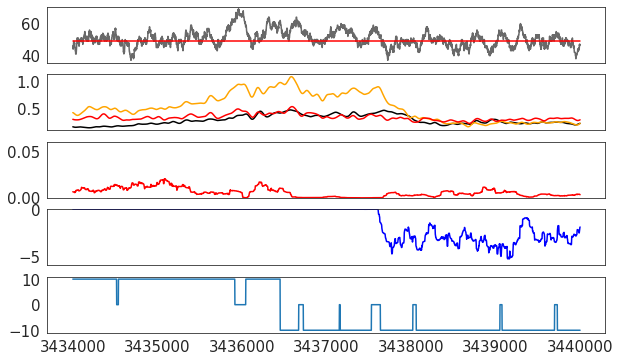

In [4]:
#Fig 2B, rib protein operon
start = 3434000
end = 3440000
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10,6), sharey=False)
axes[0].plot(np.arange(start, end),sliding_100[0][start:end],'dimgrey')
axes[0].plot([start, end],[np.mean(sliding_100[0]),np.mean(sliding_100[0])],'red')
axes[1].plot(np.arange(start, end),chip.wtH[start:end],'black')
axes[1].plot(np.arange(start, end),chip.high[start:end],'orange')
axes[1].plot(np.arange(start, end),chip.Rif_high[start:end],'red')

axes[2].plot(np.arange(start, end),(RNAseq['fwd'][start:end]),'red')
axes[3].plot(np.arange(start, end),-(RNAseq['rev'][start:end]),'blue')

axes[2].set_ylim(0, 0.06)
axes[3].set_ylim(-6, 0)

axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)
axes[3].get_xaxis().set_visible(False)

axes[4].plot(np.arange(start, end), genome_gene_representation[0,start:end])

### Fig. 2C

In [5]:
#Uses only one operon in convergent / divergent orientation to prevent double counting
operonLen = 1500
N = 1000
plus = MGoperons[(MGoperons.strand == 0) & (MGoperons.newRPK>=0) & (MGoperons.end-MGoperons.start >= operonLen)]
minus = MGoperons[(MGoperons.strand == 1) & (MGoperons.newRPK>=0) & (MGoperons.end-MGoperons.start >= operonLen)]

t = []
for index, values in plus.iterrows():
    x = (minus[(minus.start >= values.end) & (minus.start <= values.end+1000)])
    if len(x) != 0:
        t.append(x)

t2 = []
for index, values in minus.iterrows():
    x = (plus[(plus.start >= values.start) & (plus.start <= values.end+1000)])
    if len(x) != 0:
        t2.append(x)

minus_new = minus.copy()
for x in t:
    minus_new.drop(index = x.index,inplace=True)
    
plus_new = plus.copy()
for x in t2:
    plus_new.drop(index = x.index,inplace=True)

t-test of end of TUs: 3.284 Ttest_indResult(statistic=7.548116052705982, pvalue=1.203739258356844e-13)
t-test of end of TUs: 25.7 Ttest_indResult(statistic=9.655877865149824, pvalue=2.4622253271351495e-20)
t-test of end of TUs: 65 Ttest_indResult(statistic=10.458820914985315, pvalue=1.2722589864731118e-22)


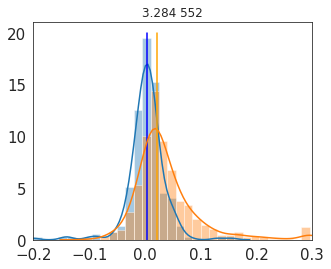

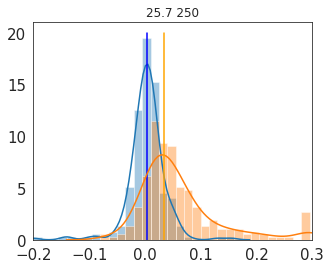

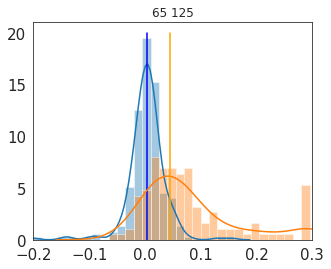

In [6]:
#different transcriptional cutoffs, 3pr end
#figure titles indicate rpkm cutoff and number of TUs
operonLen = 1500
N = 1000
thrsh_x_2 = 3.284

rand_prob_3pr = {}
for thrsh_x in [3.284,25.7,65]:
    data_y_end, data_y_start, data_y2_end, data_y2_start = [],[],[],[]
    for index, values in plus[1:].iterrows():
        if values.newRPK > thrsh_x:
            end = int(values.end)
            if end < len(MG1655)-N:
                data_y_end.append((np.sum(chip.high.values[end:end+N])/N-np.sum(chip.Rif_high.values[end:end+N])/N)-(np.sum(chip.high.values[end-N:end])/N-np.sum(chip.Rif_high.values[end-N:end])/N))
                
        elif values.newRPK < thrsh_x_2:
            end = int(values.end)
            if end < len(MG1655)-N:
                data_y2_end.append((np.sum(chip.high.values[end:end+N])/N-np.sum(chip.Rif_high.values[end:end+N])/N)-(np.sum(chip.high.values[end-N:end])/N-np.sum(chip.Rif_high.values[end-N:end])/N))
    data_y_plus_end=data_y_end
    data_y_plus_end_2=data_y2_end
    data_y_plus_start=data_y_start
    data_y_plus_start_2=data_y2_start


    data_y_end, data_y_start, data_y2_end, data_y2_start = [],[],[],[]
    for index, values in minus_new.iterrows():
        if values.newRPK > thrsh_x:
            end = int(values.start)
            if end > N:
                data_y_end.append((np.sum(chip.high.values[end-N:end])/N-np.sum(chip.Rif_high.values[end-N:end])/N)-(np.sum(chip.high.values[end:end+N])/N-np.sum(chip.Rif_high.values[end:end+N])/N))
                
        elif values.newRPK < thrsh_x_2:
            end = int(values.start)
            if end > N:
                data_y2_end.append((np.sum(chip.high.values[end-N:end])/N-np.sum(chip.Rif_high.values[end-N:end])/N)-(np.sum(chip.high.values[end:end+N])/N-np.sum(chip.Rif_high.values[end:end+N])/N))
                
    data_y_rev_end=data_y_end
    data_y_rev_end_2=data_y2_end
    data_y_rev_start=data_y_start
    data_y_rev_start_2=data_y2_start

    data_y_concat_end=np.concatenate((data_y_plus_end,data_y_rev_end))
    data_y_concat_2_end=np.concatenate((data_y_plus_end_2,data_y_rev_end_2))
    data_y_concat_start=np.concatenate((data_y_plus_start,data_y_rev_start))
    data_y_concat_2_start=np.concatenate((data_y_plus_start_2,data_y_rev_start_2))

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
    bins = np.arange(-0.2,0.3,0.015)
    sns.distplot(np.clip(data_y_concat_2_end,bins[0],bins[-1]),bins)#,fit=norm, kde=False)
    kde = stats.gaussian_kde(data_y_concat_2_end)
    xs = np.linspace(-0.3, 0.3, 100)
    y1 = kde(xs)
    plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,20],'-',color='blue')
    
    bins = np.arange(-0.2,0.3,0.015)
    sns.distplot(np.clip(data_y_concat_end,bins[0],bins[-1]),bins)#,fit=norm, kde=False)
    kde = stats.gaussian_kde(data_y_concat_end)
    xs = np.linspace(-0.3, 0.3, 100)
    y1 = kde(xs)
    plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,20],'-',color='orange')
    
    plt.xlim([-0.2,0.3])

    axes.set_title(str(thrsh_x)+' '+str(len(data_y_concat_end)))

    print('t-test of end of TUs: '+ str(thrsh_x) + ' '+ str(stats.ttest_ind(data_y_concat_end,data_y_concat_2_end)))

t-test of end of TUs: 3.284 Ttest_indResult(statistic=-0.19407411928839707, pvalue=0.8461679916942154)
t-test of end of TUs: 25.7 Ttest_indResult(statistic=0.41957582896196516, pvalue=0.6749766514168105)
t-test of end of TUs: 65 Ttest_indResult(statistic=2.0917185678569137, pvalue=0.037146842259537786)


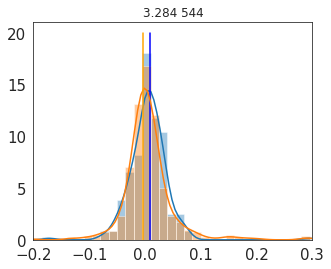

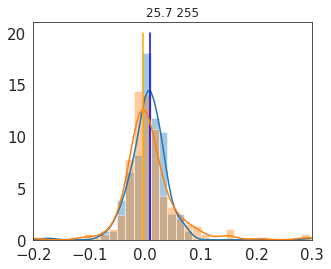

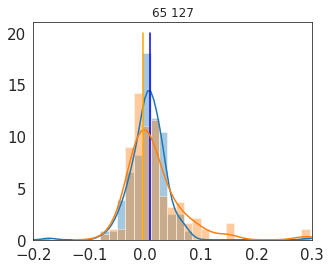

In [7]:
#different transcriptional cutoffs, 5pr end
#figure titles indicate rpkm cutoff and number of TUs
operonLen = 1500
N = 1000
thrsh_x_2 = 3.284

rand_prob_3pr = {}
for thrsh_x in [3.284,25.7,65]:
    data_y_end, data_y_start, data_y2_end, data_y2_start = [],[],[],[]
    for index, values in plus_new.iterrows():
        if values.newRPK > thrsh_x:
            start = int(values.start)
            if start > N:
                data_y_start.append((np.sum(chip.high.values[start-N:start])/N-np.sum(chip.Rif_high.values[start-N:start])/N)-(np.sum(chip.high.values[start:start+N])/N-np.sum(chip.Rif_high.values[start:start+N])/N))
        elif values.newRPK < thrsh_x_2:
            start = int(values.start)
            if start > N:
                data_y2_start.append((np.sum(chip.high.values[start-N:start])/N-np.sum(chip.Rif_high.values[start-N:start])/N)-(np.sum(chip.high.values[start:start+N])/N-np.sum(chip.Rif_high.values[start:start+N])/N))
    data_y_plus_end=data_y_end
    data_y_plus_end_2=data_y2_end
    data_y_plus_start=data_y_start
    data_y_plus_start_2=data_y2_start


    data_y_end, data_y_start, data_y2_end, data_y2_start = [],[],[],[]
    for index, values in minus.iterrows():
        if values.newRPK > thrsh_x:
            start = int(values.end)
            if start < len(MG1655)-N:
                data_y_start.append((np.sum(chip.high.values[start:start+N])/N-np.sum(chip.Rif_high.values[start:start+N])/N)-(np.sum(chip.high.values[start-N:start])/N-np.sum(chip.Rif_high.values[start-N:start])/N))
        elif values.newRPK < thrsh_x_2:
            start = int(values.end)
            if start < len(MG1655)-N:
                data_y2_start.append((np.sum(chip.high.values[start:start+N])/N-np.sum(chip.Rif_high.values[start:start+N])/N)-(np.sum(chip.high.values[start-N:start])/N-np.sum(chip.Rif_high.values[start-N:start])/N))
                
    data_y_rev_end=data_y_end
    data_y_rev_end_2=data_y2_end
    data_y_rev_start=data_y_start
    data_y_rev_start_2=data_y2_start

    data_y_concat_end=np.concatenate((data_y_plus_end,data_y_rev_end))
    data_y_concat_2_end=np.concatenate((data_y_plus_end_2,data_y_rev_end_2))
    data_y_concat_start=np.concatenate((data_y_plus_start,data_y_rev_start))
    data_y_concat_2_start=np.concatenate((data_y_plus_start_2,data_y_rev_start_2))

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
    bins = np.arange(-0.2,0.3,0.015)
    sns.distplot(np.clip(data_y_concat_2_start,bins[0],bins[-1]),bins)#,fit=norm, kde=False)
    kde = stats.gaussian_kde(data_y_concat_2_start)
    xs = np.linspace(-0.3, 0.3, 100)
    y1 = kde(xs)
    plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,20],'-',color='blue')
    
    bins = np.arange(-0.2,0.3,0.015)
    sns.distplot(np.clip(data_y_concat_start,bins[0],bins[-1]),bins)#,fit=norm, kde=False)
    kde = stats.gaussian_kde(data_y_concat_start)
    xs = np.linspace(-0.3, 0.3, 100)
    y1 = kde(xs)
    plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,20],'-',color='orange')
    
    plt.xlim([-0.2,0.3])

    axes.set_title(str(thrsh_x)+' '+str(len(data_y_concat_start)))

    print('t-test of end of TUs: '+ str(thrsh_x) + ' '+ str(stats.ttest_ind(data_y_concat_start,data_y_concat_2_start)))

### Fig. 2D

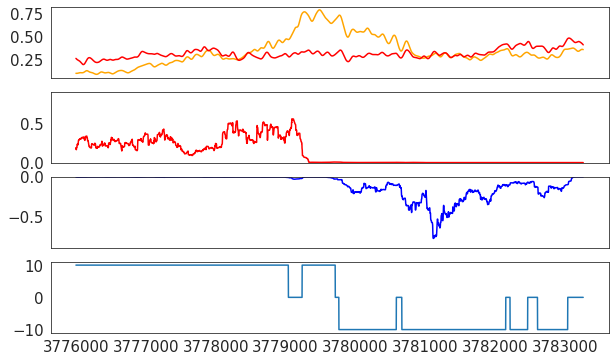

In [8]:
start=3776000
end=3783261
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,6), sharey=False)
axes[0].plot(np.arange(start, end),chip.high[start:end],'orange')
axes[0].plot(np.arange(start, end),chip.Rif_high[start:end],'red')

axes[1].plot(np.arange(start, end),(RNAseq['fwd'][start:end]),'red')
axes[2].plot(np.arange(start, end),-(RNAseq['rev'][start:end]),'blue')
axes[1].set_ylim([0,0.9])
axes[2].set_ylim([-0.9,0])

axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)

axes[3].plot(np.arange(start, end), genome_gene_representation[0,start:end])

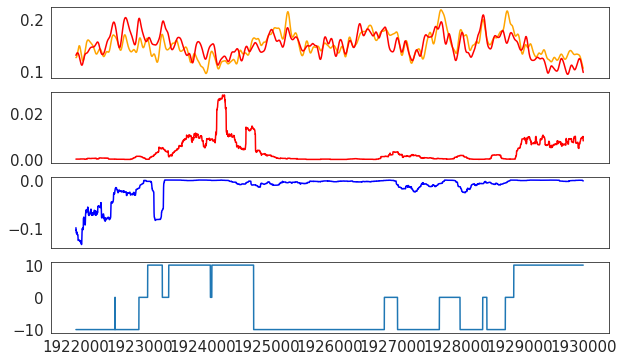

In [9]:
start=1922000
end=1930000
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,6), sharey=False)
axes[0].plot(np.arange(start, end),chip.high[start:end],'orange')
axes[0].plot(np.arange(start, end),chip.Rif_high[start:end],'red')

axes[1].plot(np.arange(start, end),(RNAseq['fwd'][start:end]),'red')
axes[2].plot(np.arange(start, end),-(RNAseq['rev'][start:end]),'blue')

axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)

axes[3].plot(np.arange(start, end), genome_gene_representation[0,start:end])

### Fig. 2E

/home/msguo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/msguo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


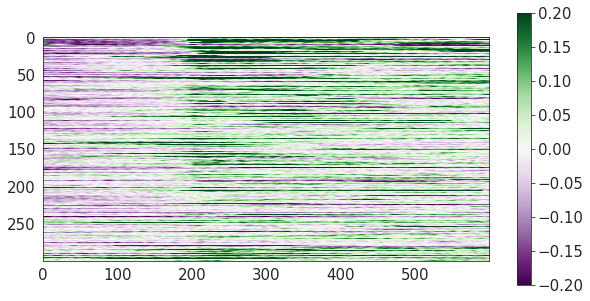

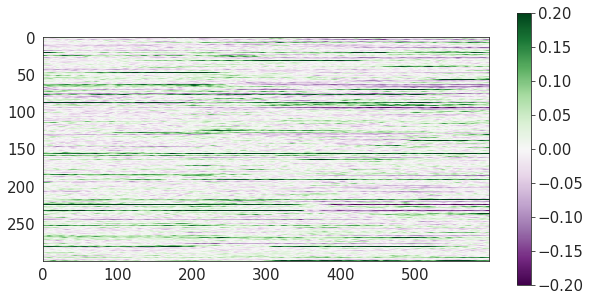

In [10]:
#heatmaps for 5pr/3pr GapR enrichment based on transcriptional level, this is the 3pr end
chip_diff = chip.high-chip.Rif_high

GapEnrich = []
rpkM = []
ind = []
for i, j in MGoperons[1:-2].iterrows():
    if j.end-j.start >=1500:
        if j.newRPK >= 0:
            rpkM.append(j.newRPK)
            ind.append(i)
            if j.strand == 0:
                GapEnrich.append(chip_diff[j.end-2000:j.end+4000].values)
            else:
                GapEnrich.append(chip_diff[j.start-4000:j.start+2000].values[::-1])

binSize = 10
out = []
for j in range(len(GapEnrich)):
    a = []
    for i in range(0,6000,binSize):
        a.append(np.mean(GapEnrich[j][i:i+10]))
    out.append(a)
    
newMat = pd.DataFrame([rpkM,out],['rpkM','thrends']).transpose()
newMat.sort_values('rpkM',ascending=False,inplace=True)

sortedGapEnrich = []
for i,j in newMat.iterrows():
    sortedGapEnrich.append(j.thrends)
    
#high expression heatmap
plt.figure(figsize = [10,5])
plt.imshow(sortedGapEnrich[0:300],vmin=-0.20,vmax=0.20,cmap='PRGn')
plt.colorbar()

#low expression heatmap
plt.figure(figsize = [10,5])
plt.imshow(sortedGapEnrich[-300:],vmin=-0.20,vmax=0.20,cmap='PRGn')
plt.colorbar()

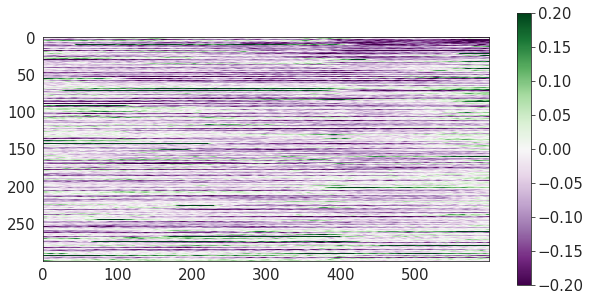

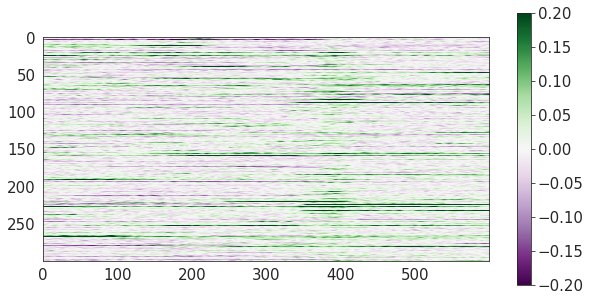

In [11]:
#heatmaps for 5pr/3pr GapR enrichment based on transcriptional level, this is the 5pr end
GapEnrich = []
rpkM = []
ind = []
for i, j in MGoperons[1:-2].iterrows():
    if j.end-j.start >=1500:
        if j.newRPK >= 0:
            rpkM.append(j.newRPK)
            ind.append(i)
            if j.strand == 0:
                GapEnrich.append(chip_diff[j.start-4000:j.start+2000].values)
            else:
                GapEnrich.append(chip_diff[j.end-2000:j.end+4000].values[::-1])
            
binSize = 10

out = []
for j in range(len(GapEnrich)):
    a = []
    for i in range(0,6000,binSize):
        a.append(np.mean(GapEnrich[j][i:i+10]))
    out.append(a)
    
newMat = pd.DataFrame([rpkM,out],['rpkM','thrends']).transpose()
newMat.sort_values('rpkM',ascending=False,inplace=True)

sortedGapEnrich = []
for i,j in newMat.iterrows():
    sortedGapEnrich.append(j.thrends)
    
#high expression heatmap
plt.figure(figsize = [10,5])
plt.imshow(sortedGapEnrich[0:300],vmin=-0.20,vmax=0.20,cmap='PRGn')
plt.colorbar()

#low expression heatmap
plt.figure(figsize = [10,5])
plt.imshow(sortedGapEnrich[-300:],vmin=-0.20,vmax=0.20,cmap='PRGn')
plt.colorbar()

### Fig. 2-figure supplement 1A

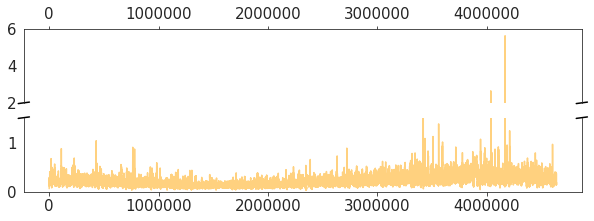

In [12]:
#Fig. S2A_1 GapR-3xFLAG ChIP
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,3),sharex=True)
startplot=1
endplot=len(chip.high)
axes[0].plot(np.arange(startplot, endplot,25), chip.high[startplot:endplot:25], 'orange',alpha = 0.5)
axes[1].plot(np.arange(startplot, endplot,25), chip.high[startplot:endplot:25], 'orange',alpha = 0.5)

# zoom-in / limit the view to different portions of the data
axes[0].set_ylim(2.0, 6)  # outliers only
axes[1].set_ylim(0, 1.5)  # most of the data

# hide the spines between ax and ax2
axes[0].spines['bottom'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[0].xaxis.tick_top()
axes[0].tick_params(labeltop='off')  # don't put tick labels at the top
axes[1].xaxis.tick_bottom()
#fig.subplots_adjust(hspace=0.1)

d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=axes[0].transAxes, color='k', clip_on=False)
axes[0].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
axes[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=axes[1].transAxes)  # switch to the bottom axes
axes[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
axes[1].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


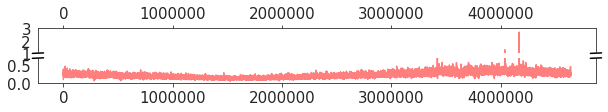

In [13]:
#Fig. S2A_2 GapR-3xFLAG ChIP + rif
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,1),sharex=True)
startplot=1
endplot=len(chip.high)
axes[0].plot(np.arange(startplot, endplot,25), chip.Rif_high[startplot:endplot:25], 'red',alpha = 0.5)
axes[1].plot(np.arange(startplot, endplot,25), chip.Rif_high[startplot:endplot:25], 'red',alpha = 0.5)
# zoom-in / limit the view to different portions of the data
axes[0].set_ylim(1, 3)  # outliers only
axes[1].set_ylim(0, 0.7)  # most of the data

# hide the spines between ax and ax2
axes[0].spines['bottom'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[0].xaxis.tick_top()
axes[0].tick_params(labeltop='off')  # don't put tick labels at the top
axes[1].xaxis.tick_bottom()
#fig.subplots_adjust(hspace=0.1)

d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=axes[0].transAxes, color='k', clip_on=False)
axes[0].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
axes[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=axes[1].transAxes)  # switch to the bottom axes
axes[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
axes[1].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

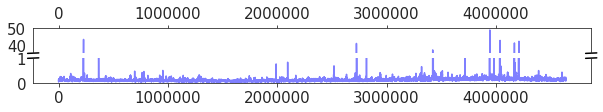

In [14]:
#Fig. S2A_3 GapR ChIP
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,1),sharex=True)
startplot=1
endplot=len(chip.high)
axes[0].plot(np.arange(startplot, endplot,25), chip.wtH[startplot:endplot:25], 'blue', alpha=0.5)
axes[1].plot(np.arange(startplot, endplot,25), chip.wtH[startplot:endplot:25], 'blue', alpha=0.5)

# zoom-in / limit the view to different portions of the data
axes[1].set_ylim(0,1)  # outliers only
axes[0].set_ylim(35, 50)  # most of the data

# hide the spines between ax and ax2
axes[0].spines['bottom'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[0].xaxis.tick_top()
axes[0].tick_params(labeltop='off')  # don't put tick labels at the top
axes[1].xaxis.tick_bottom()

d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=axes[0].transAxes, color='k', clip_on=False)
axes[0].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
axes[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=axes[1].transAxes)  # switch to the bottom axes
axes[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
axes[1].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

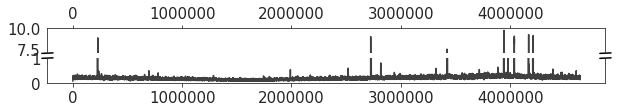

In [15]:
#Fig. S2A_4 GapR-3xFLAG no aTc ChIP
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,1),sharex=True)
startplot=1
endplot=len(chip.high)
axes[0].plot(np.arange(startplot, endplot,25), chip.neg[startplot:endplot:25], 'k', alpha = 0.75)
axes[1].plot(np.arange(startplot, endplot,25), chip.neg[startplot:endplot:25], 'k', alpha = 0.75)

# zoom-in / limit the view to different portions of the data
axes[1].set_ylim(0,1)  # outliers only
axes[0].set_ylim(7, 10)  # most of the data

# hide the spines between ax and ax2
axes[0].spines['bottom'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[0].xaxis.tick_top()
axes[0].tick_params(labeltop='off')  # don't put tick labels at the top
axes[1].xaxis.tick_bottom()

d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=axes[0].transAxes, color='k', clip_on=False)
axes[0].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
axes[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=axes[1].transAxes)  # switch to the bottom axes
axes[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
axes[1].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

### Fig. 2-figure supplement 1C

In [16]:
#Exclude rRNA loci
chip_high_mask = maskrRNA(chip.high.astype(float))
chip_high2_mask = maskrRNA(chip.high_rep2.astype(float))
chip_wtH_mask = maskrRNA(chip.wtH.astype(float))
chip_wtH2_mask = maskrRNA(chip.wtH_rep2.astype(float))

(0.9796527752821199, 0.0)


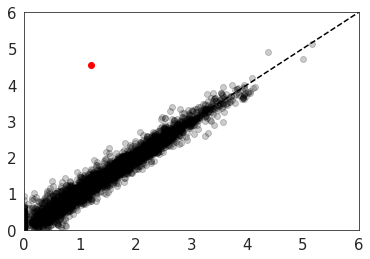

In [17]:
#correlation between gene expression +/- aTc in GapR-3xFLAG strain. Red dot indicates gapR-3xFLAG transcript
plt.plot(np.log10(RNA_G3xFneg.rpkM[:-1]+1), np.log10(RNA_G3xFH.rpkM[:-1]+1),'o',color='k',alpha=0.2)
plt.scatter(np.log10(RNA_G3xFneg[RNA_G3xFneg.geneName == 'gapR'].rpkM.values), np.log10(RNA_G3xFH[RNA_G3xFH.geneName == 'gapR'].rpkM.values),color='red')
plt.plot([0,6],[0,6],'--',color = 'k')
plt.xlim([0,6])
plt.ylim([0,6])
print(stats.pearsonr(np.log10(RNA_G3xFneg.rpkM[:-1]+1), np.log10(RNA_G3xFH.rpkM[:-1]+1)))

### Fig. 2-figure supplement 1D

In [18]:
#from peter et al 2004 (cozzarelli), top 10% of genes of each class:
relax_repressed = ['yraM','dapA','yraN','pgi','ribF','ileS','yhaJ','crl','pepA','yihE','yadF','yfgA','mukF','ydiJ','glmS','gcvR','pnp','cpxA','polA','sbcB']
relax_repressed = ['yraM','dapA','yraN','pgi','ribF','ileS','yhaJ','crl','pepA','rdoA','can','yfgA','mukF','ydiJ','glmS','gcvR','pnp','cpxA','polA','sbcB']

relax_induced = ['mcrB','htrL','b1983','b1170','deoC','mcrC','fixA','b1330','deoA','yleB','rfaI']
relax_induced = ['mcrB','htrL','yeeN','ycgH','deoC','mcrC','fixA','ynaI','deoA','ubiF','rfaI']

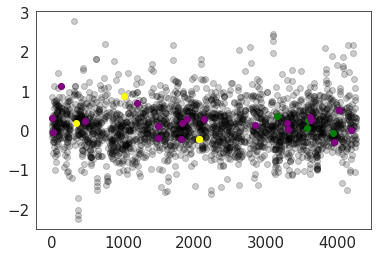

In [19]:
RNA = RNA_G3xFH.copy()
RNA['G3xFneg'] = RNA_G3xFneg.rpkM.copy()
RNA['H/neg'] = np.log2((RNA_G3xFH.rpkM+1)/(RNA_G3xFneg.rpkM+1))

topos = RNA[RNA.geneName.isin(['gyrA','gyrB','parC','parE'])].index.values
cutoff = RNA[(RNA['rpkM']>20) | (RNA['G3xFneg'] > 20)]
fold_ch = cutoff[(cutoff['H/neg'] >=2 ) | (cutoff['H/neg'] <= -2)].index.values

plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

plt.plot(cutoff['H/neg'][:-1],'o',color='k',alpha=0.2)
plt.plot(cutoff[cutoff.index.isin(topos)]['H/neg'],'o',color='green')
plt.plot(cutoff[cutoff.geneName.isin(relax_induced)]['H/neg'],'o',color='yellow')
plt.plot(cutoff[cutoff.geneName.isin(relax_repressed)]['H/neg'],'o',color='purple')

### Fig. 2-figure supplement 1E

In [20]:
#Exclude rRNA loci
chip_high_mask = maskrRNA(chip.high.astype(float))
chip_high2_mask = maskrRNA(chip.high_rep2.astype(float))
chip_wtH_mask = maskrRNA(chip.wtH.astype(float))
chip_wtH2_mask = maskrRNA(chip.wtH_rep2.astype(float))

h1 = np.nancumsum(chip_high_mask)
h2 = np.nancumsum(chip_high2_mask)

In [21]:
#bin data
N = 100
avgapR_highrep1 = []
avgapR_highrep2 = []
for x in np.arange(0,len(ecolifasta.seq),N):
    try:
        avgapR_highrep1.append((h1[x+N]-h1[x])/N)
        avgapR_highrep2.append((h2[x+N]-h2[x])/N)
    except:
        avgapR_highrep1.append((h1[len(ecolifasta.seq)-1]-h1[x])/N)
        avgapR_highrep2.append((h2[len(ecolifasta.seq)-1]-h2[x])/N)


(0.9365654221770416, 0.0)


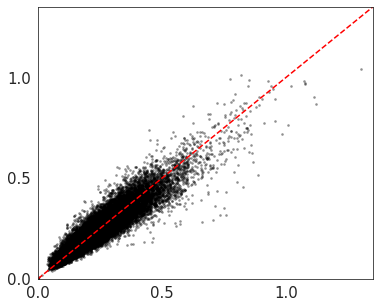

In [22]:
#Generate correlation plot
plt.figure(figsize=(6,5))
plt.scatter(avgapR_highrep1,avgapR_highrep2, marker = 'o', s = 3, c = 'black', edgecolors = 'face', alpha = 0.3)
plt.plot([0,1.35],[0,1.35],'--',c='red')
plt.xlim([0,1.35])
plt.ylim([0,1.35])
plt.xticks([0,0.5,1.0],size = 15)
plt.yticks([0,0.5,1.0],size = 15)
print(stats.pearsonr(avgapR_highrep1,avgapR_highrep2))

### Fig. 2-figure supplement 1F

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


(1, 100)

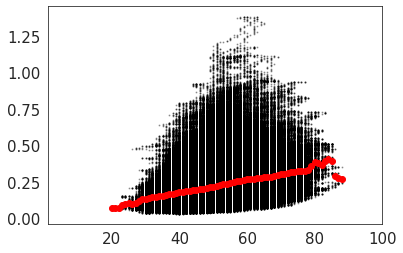

In [23]:
#generate AT content vs e coli genome, excluding rRNA loci
chip_high_mask = maskrRNA(chip.high.astype(float))
chip_wtH_mask = maskrRNA(chip.wtH.astype(float))

avgapR = []
for i in range(10,90):
    avgapR.append(np.nanmean(chip_high_mask[(sliding_100[0]>=i) & (sliding_100[0]<i+1)]))

plt.scatter(sliding_100[0],chip_high_mask, marker = 'o', s = 1, c = 'black', edgecolors = 'face', alpha = 0.3)
plt.scatter(range(10,90),avgapR,c='red',marker = 'o')
plt.xlim([1,100])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


(1, 100)

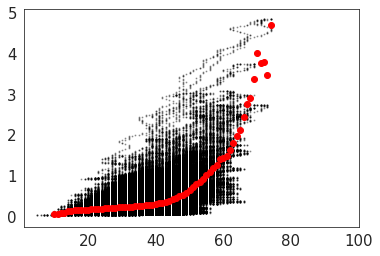

In [24]:
sliding_100_caulo=sliding_window_caulo(100)

avgapR_caulo = []
for i in range(10,90):
    avgapR_caulo.append(np.nanmean(caulo['gapR'][(sliding_100_caulo[0]>=i) & (sliding_100_caulo[0]<i+1)]))

plt.scatter(sliding_100_caulo[0],caulo['gapR'], marker = 'o', s = 1, c = 'black', edgecolors = 'face', alpha = 0.3)
plt.scatter(range(10,90),avgapR_caulo,c='red',marker = 'o')
plt.xlim([1,100])

In [25]:
#Caulo motif
out_356 = enrichedRegions(caulo.gapR,1.5)
seq_356 = getSequence(out_356, caulo.gapR,caulobacterfasta, 'chip_caulo.test')
outu_356 = unenrichedRegions(caulo.gapR,0.3)
sequ_356 = getuSequence(outu_356, caulo.gapR,caulobacterfasta, 'chip_caulo_unbound.test')
print(len(seq_356),len(sequ_356))

35 1552


In [26]:
#e coli motif
out_high = enrichedRegions(chip.high,0.843)
seq_high = getSequence(out_high, chip.high,ecolifasta, 'chip_high.test') #this output is submitted to DREME
outu_high = unenrichedRegions(chip.high,0.30)
sequ_high = getuSequence(outu_high, chip.high, ecolifasta, 'chip_high_unbound.test') #this output is submitted to DREME
print(len(seq_high),len(sequ_high))

35 1417


### Fig 2-figure supplement 1G

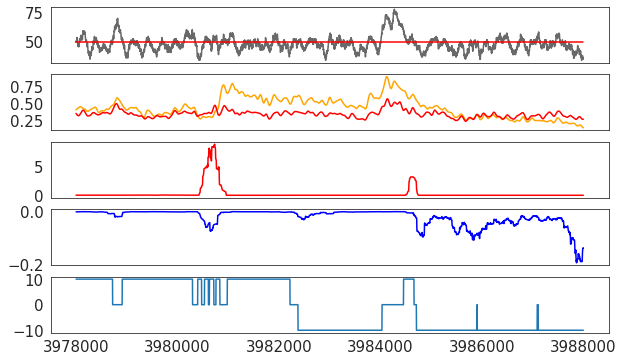

In [27]:
#Fig S2G, GapR at tRNA representative example
start=3978000
end=3988000
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10,6), sharey=False)
axes[0].plot(np.arange(start, end),sliding_100[0][start:end],'dimgrey')
axes[0].plot([start, end],[np.mean(sliding_100[0]),np.mean(sliding_100[0])],'red')
#axes[1].plot(np.arange(start, end),chip.wtH[start:end],'black')
axes[1].plot(np.arange(start, end),chip.high[start:end],'orange')
axes[1].plot(np.arange(start, end),chip.Rif_high[start:end],'red')

axes[2].plot(np.arange(start, end),(RNAseq['fwd'][start:end]),'red')
axes[3].plot(np.arange(start, end),-(RNAseq['rev'][start:end]),'blue')

axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)
axes[3].get_xaxis().set_visible(False)

axes[4].plot(np.arange(start, end), genome_gene_representation[0,start:end])

### Fig. 2-figure supplement 1H

In [28]:
df_regions = pd.concat([annote,annote.shift(-1)],axis=1,keys=['left','right'],names=['geneName'])
df_regions.columns = ['{}_{}'.format(x,y) for x,y in df_regions.columns]
df_regions = df_regions.dropna(subset=['right_start'])

In [29]:
chip_diff = chip.high
df_regions['intergenic_mean_gapR']=df_regions.apply(lambda r:chip_diff[int(r['left_end']):int(r['right_start'])].mean(),axis=1)
df_regions['intergenic_length']=df_regions.apply(lambda r:int(r['right_start'])-int(r['left_end']),axis=1)
df_regions['genic_mean_gapR']=df_regions.apply(lambda r:chip_diff[int(r['left_start']):int(r['left_end'])].mean(),axis=1)
df_final = df_regions[df_regions.intergenic_length >50] #filter out things that are within X bases

t-test gene vs inter: Ttest_indResult(statistic=12.6972591991313, pvalue=2.270021231448779e-36)


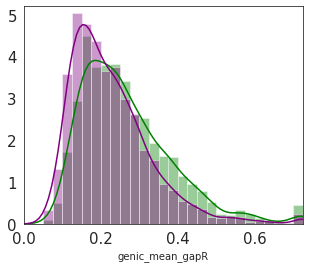

In [30]:
plt.figure(figsize=(5,4))
bins = np.arange(0,0.75,0.025)
sns.distplot(np.clip(df_final['intergenic_mean_gapR'],bins[0],bins[-1]),bins=bins,color='green')
sns.distplot(np.clip(df_final['genic_mean_gapR'],bins[0],bins[-1]),bins=bins,color='purple')
plt.xlim([bins[0],bins[-1]])
plt.ylim([0,5.2])
print('t-test gene vs inter: '+ str(stats.ttest_ind(df_final['intergenic_mean_gapR'],df_final['genic_mean_gapR'])))

### Fig 2-figure supplement 1I

In [31]:
#Uses only one operon in convergent / divergent orientation to prevent double counting
operonLen = 1500
N = 1000
plus = MGoperons[(MGoperons.strand == 0) & (MGoperons.newRPK>=0) & (MGoperons.end-MGoperons.start >= operonLen)]
minus = MGoperons[(MGoperons.strand == 1) & (MGoperons.newRPK>=0) & (MGoperons.end-MGoperons.start >= operonLen)]

t = []
for index, values in plus.iterrows():
    x = (minus[(minus.start >= values.end) & (minus.start <= values.end+1000)])
    if len(x) != 0:
        t.append(x)

t2 = []
for index, values in minus.iterrows():
    x = (plus[(plus.start >= values.start) & (plus.start <= values.end+1000)])
    if len(x) != 0:
        t2.append(x)

#redo 5' and 3' with dropping?
minus_new = minus.copy()
for x in t:
    minus_new.drop(index = x.index,inplace=True)
    
plus_new = plus.copy()
for x in t2:
    plus_new.drop(index = x.index,inplace=True)

t-test of start of TUs: Ttest_indResult(statistic=-6.769590713745673, pvalue=1.811717147619292e-11)


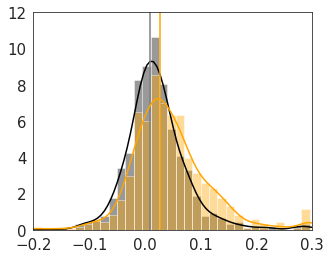

In [32]:
#Calculate GapR-3xFLAG and generate figure
minus_new = minus.copy()
for x in t:
    minus_new.drop(index = x.index,inplace=True)
    
data_y_end, data_y_start, data_y2_end, data_y2_start = [],[],[],[]
for index, values in plus[1:].iterrows():
    end = int(values.end)
    if end < len(MG1655)-N:
        data_y_end.append(np.sum(chip.high.values[end:end+N])/N-np.sum(chip.high.values[end-N:end])/N)
for index, values in plus_new[1:].iterrows():
    start = int(values.start)
    if start > N:
        data_y_start.append(np.sum(chip.high.values[start-N:start])/N-np.sum(chip.high.values[start:start+N])/N)

data_y_plus_end=data_y_end
data_y_plus_start=data_y_start

data_y_end, data_y_start, data_y2_end, data_y2_start = [],[],[],[]
for index, values in minus_new.iterrows():
    end = int(values.start)
    if end > N:
        data_y_end.append(np.sum(chip.high.values[end-N:end])/N-np.sum(chip.high.values[end:end+N])/N)
for index, values in minus.iterrows():
    start = int(values.end)
    if start < len(MG1655)-N:
        data_y_start.append(np.sum(chip.high.values[start:start+N])/N-np.sum(chip.high.values[start-N:start])/N)

        data_y_rev_end=data_y_end
data_y_rev_start=data_y_start

data_y_concat_2_end=np.concatenate((data_y_plus_end,data_y_rev_end))
data_y_concat_2_start=np.concatenate((data_y_plus_start,data_y_rev_start))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
bins = np.arange(-0.20,0.3,0.015)

sns.distplot(np.clip(data_y_concat_2_start,bins[0],bins[-1]),bins=bins, norm_hist=True, color='black')#,fit=norm, kde=False)
kde = stats.gaussian_kde(data_y_concat_2_start)
xs = np.linspace(-0.3, 0.3, 100)
y1 = kde(xs)
plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,20],'-',color='grey')
sns.distplot(np.clip(data_y_concat_2_end,bins[0],bins[-1]),bins=bins, norm_hist=True,color='orange')#,fit=norm, kde=False)
kde = stats.gaussian_kde(data_y_concat_2_end)
xs = np.linspace(-0.3, 0.3, 100)
y1 = kde(xs)
plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,20],'-',color='orange')
plt.xlim([-0.20,0.3])
plt.ylim([0,12])
print('t-test of start of TUs: '+ str(stats.ttest_ind(data_y_concat_2_start,data_y_concat_2_end)))

### Fig. 2-figure supplement 1J

In [33]:
#Uses only one operon in convergent / divergent orientation to prevent double counting
operonLen = 1500
N = 1000
plus = MGoperons[(MGoperons.strand == 0) & (MGoperons.newRPK>=0) & (MGoperons.end-MGoperons.start >= operonLen)]
minus = MGoperons[(MGoperons.strand == 1) & (MGoperons.newRPK>=0) & (MGoperons.end-MGoperons.start >= operonLen)]

t = []
for index, values in plus.iterrows():
    x = (minus[(minus.start >= values.end) & (minus.start <= values.end+1000)])
    if len(x) != 0:
        t.append(x)

t2 = []
for index, values in minus.iterrows():
    x = (plus[(plus.start >= values.start) & (plus.start <= values.end+1000)])
    if len(x) != 0:
        t2.append(x)

#redo 5' and 3' with dropping?
minus_new = minus.copy()
for x in t:
    minus_new.drop(index = x.index,inplace=True)
    
plus_new = plus.copy()
for x in t2:
    plus_new.drop(index = x.index,inplace=True)

t-test of start of TUs: Ttest_indResult(statistic=-7.800714954377853, pvalue=1.1073063943881298e-14)


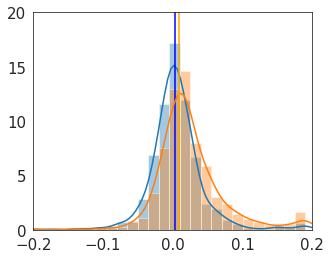

In [34]:
#Calculate transcription-dependent change in GapR-3xFLAG and generate figure
data_y_end, data_y_start = [],[]
for index, values in plus[1:].iterrows():
    end = int(values.end)
    if end < len(MG1655)-N:
        data_y_end.append((np.sum(chip.high.values[end:end+N])/N-np.sum(chip.Rif_high.values[end:end+N])/N)-(np.sum(chip.high.values[end-N:end])/N-np.sum(chip.Rif_high.values[end-N:end])/N))
for index, values in plus_new[1:].iterrows():
    start = int(values.start)
    if start > N:
        data_y_start.append((np.sum(chip.high.values[start-N:start])/N-np.sum(chip.Rif_high.values[start-N:start])/N)-(np.sum(chip.high.values[start:start+N])/N-np.sum(chip.Rif_high.values[start:start+N])/N))


data_y_plus_end=data_y_end
data_y_plus_start=data_y_start

data_y_end, data_y_start, data_y2_end, data_y2_start = [],[],[],[]
for index, values in minus_new.iterrows():
    end = int(values.start)
    if end > N:
        data_y_end.append((np.sum(chip.high.values[end-N:end])/N-np.sum(chip.Rif_high.values[end-N:end])/N)-(np.sum(chip.high.values[end:end+N])/N-np.sum(chip.Rif_high.values[end:end+N])/N))
for index, values in minus.iterrows():
    start = int(values.end)
    if start < len(MG1655)-N:
        data_y_start.append((np.sum(chip.high.values[start:start+N])/N-np.sum(chip.Rif_high.values[start:start+N])/N)-(np.sum(chip.high.values[start-N:start])/N-np.sum(chip.Rif_high.values[start-N:start])/N))

data_y_rev_end=data_y_end
data_y_rev_start=data_y_start

data_y_concat_2_end=np.concatenate((data_y_plus_end,data_y_rev_end))
data_y_concat_2_start=np.concatenate((data_y_plus_start,data_y_rev_start))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
bins = np.arange(-0.2,0.2,0.015)

sns.distplot(np.clip(data_y_concat_2_start,bins[0],bins[-1]),bins=bins, norm_hist=True)#,fit=norm, kde=False)
kde = stats.gaussian_kde(data_y_concat_2_start)
xs = np.linspace(-0.3, 0.3, 100)
y1 = kde(xs)
plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,20],'-',color='blue')
sns.distplot(np.clip(data_y_concat_2_end,bins[0],bins[-1]),bins=bins, norm_hist=True)#,fit=norm, kde=False)
kde = stats.gaussian_kde(data_y_concat_2_end)
xs = np.linspace(-0.3, 0.3, 100)
y1 = kde(xs)
plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,20],'-',color='orange')
plt.xlim([-0.20,0.20])
plt.ylim([0,20])
print('t-test of start of TUs: '+ str(stats.ttest_ind(data_y_concat_2_start,data_y_concat_2_end)))

### Fig. 2-figure supplement 1K

In [35]:
#Uses only one operon in convergent / divergent orientation to prevent double counting
operonLen = 1500
N = 1000
plus = MGoperons[(MGoperons.strand == 0) & (MGoperons.newRPK>=0) & (MGoperons.end-MGoperons.start >= operonLen)]
minus = MGoperons[(MGoperons.strand == 1) & (MGoperons.newRPK>=0) & (MGoperons.end-MGoperons.start >= operonLen)]

t = []
for index, values in plus.iterrows():
    x = (minus[(minus.start >= values.end) & (minus.start <= values.end+1000)])
    if len(x) != 0:
        t.append(x)

t2 = []
for index, values in minus.iterrows():
    x = (plus[(plus.start >= values.start) & (plus.start <= values.end+1000)])
    if len(x) != 0:
        t2.append(x)

#redo 5' and 3' with dropping?
minus_new = minus.copy()
for x in t:
    minus_new.drop(index = x.index,inplace=True)
    
plus_new = plus.copy()
for x in t2:
    plus_new.drop(index = x.index,inplace=True)

t-test of end of TUs: 3.284 Ttest_indResult(statistic=7.13172645489698, pvalue=2.21972282975999e-12)
t-test of end of TUs: 25.7 Ttest_indResult(statistic=9.160098861398772, pvalue=1.3493083348342838e-18)
t-test of end of TUs: 65 Ttest_indResult(statistic=9.846722584989037, pvalue=1.7333231059494166e-20)


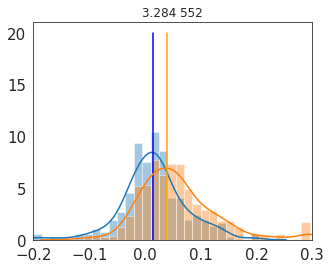

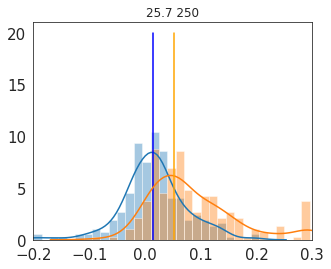

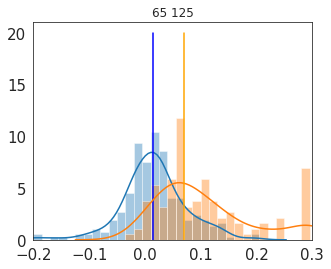

In [36]:
#GapR-3xFLAG enrichment at different transcriptional cutoffs, 3pr end
operonLen = 1500
N = 1000
thrsh_x_2 = 3.284

rand_prob_3pr = {}
for thrsh_x in [3.284,25.7,65]:
    data_y_end, data_y_start, data_y2_end, data_y2_start = [],[],[],[]
    for index, values in plus[1:].iterrows():
        if values.newRPK > thrsh_x:
            end = int(values.end)
            if end < len(MG1655)-N:
                data_y_end.append((np.sum(chip.high.values[end:end+N])/N)-(np.sum(chip.high.values[end-N:end])/N))
                
        elif values.newRPK < thrsh_x_2:
            end = int(values.end)
            if end < len(MG1655)-N:
                data_y2_end.append((np.sum(chip.high.values[end:end+N])/N)-(np.sum(chip.high.values[end-N:end])/N))
    data_y_plus_end=data_y_end
    data_y_plus_end_2=data_y2_end
    data_y_plus_start=data_y_start
    data_y_plus_start_2=data_y2_start


    data_y_end, data_y_start, data_y2_end, data_y2_start = [],[],[],[]
    for index, values in minus_new.iterrows():
        if values.newRPK > thrsh_x:
            end = int(values.start)
            if end > N:
                data_y_end.append((np.sum(chip.high.values[end-N:end])/N)-(np.sum(chip.high.values[end:end+N])/N))
                
        elif values.newRPK < thrsh_x_2:
            end = int(values.start)
            if end > N:
                data_y2_end.append((np.sum(chip.high.values[end-N:end])/N)-(np.sum(chip.high.values[end:end+N])/N))
                
    data_y_rev_end=data_y_end
    data_y_rev_end_2=data_y2_end
    data_y_rev_start=data_y_start
    data_y_rev_start_2=data_y2_start

    data_y_concat_end=np.concatenate((data_y_plus_end,data_y_rev_end))
    data_y_concat_2_end=np.concatenate((data_y_plus_end_2,data_y_rev_end_2))
    data_y_concat_start=np.concatenate((data_y_plus_start,data_y_rev_start))
    data_y_concat_2_start=np.concatenate((data_y_plus_start_2,data_y_rev_start_2))

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
    bins = np.arange(-0.2,0.3,0.015)
    sns.distplot(np.clip(data_y_concat_2_end,bins[0],bins[-1]),bins)#,fit=norm, kde=False)
    kde = stats.gaussian_kde(data_y_concat_2_end)
    xs = np.linspace(-0.3, 0.3, 100)
    y1 = kde(xs)
    plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,20],'-',color='blue')
    
    bins = np.arange(-0.2,0.3,0.015)
    sns.distplot(np.clip(data_y_concat_end,bins[0],bins[-1]),bins)#,fit=norm, kde=False)
    kde = stats.gaussian_kde(data_y_concat_end)
    xs = np.linspace(-0.3, 0.3, 100)
    y1 = kde(xs)
    plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,20],'-',color='orange')
    
    plt.xlim([-0.2,0.3])

    axes.set_title(str(thrsh_x)+' '+str(len(data_y_concat_end)))

    print('t-test of end of TUs: '+ str(thrsh_x) + ' '+ str(stats.ttest_ind(data_y_concat_end,data_y_concat_2_end)))

t-test of end of TUs: 3.284 Ttest_indResult(statistic=-0.3495821518521273, pvalue=0.7267459486877286)
t-test of end of TUs: 25.7 Ttest_indResult(statistic=0.48842974941801304, pvalue=0.6254609043590452)
t-test of end of TUs: 65 Ttest_indResult(statistic=2.250733710887248, pvalue=0.024990573873274823)


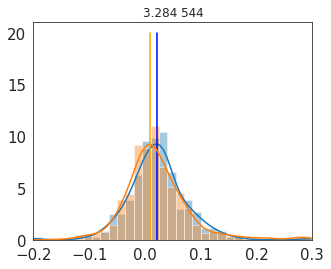

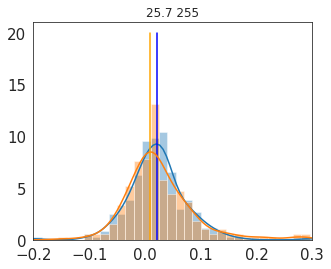

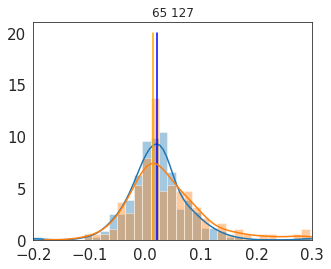

In [37]:
#GapR-3xFLAG enrichment at different transcriptional cutoffs, 3pr end
thrsh_x_2 = 3.284

rand_prob_3pr = {}
for thrsh_x in [3.284,25.7,65]:
    data_y_end, data_y_start, data_y2_end, data_y2_start = [],[],[],[]
    for index, values in plus_new.iterrows():
        if values.newRPK > thrsh_x:
            start = int(values.start)
            if start > N:
                data_y_start.append((np.sum(chip.high.values[start-N:start])/N)-(np.sum(chip.high.values[start:start+N])/N))
        elif values.newRPK < thrsh_x_2:
            start = int(values.start)
            if start > N:
                data_y2_start.append((np.sum(chip.high.values[start-N:start])/N)-(np.sum(chip.high.values[start:start+N])/N))
    data_y_plus_end=data_y_end
    data_y_plus_end_2=data_y2_end
    data_y_plus_start=data_y_start
    data_y_plus_start_2=data_y2_start


    data_y_end, data_y_start, data_y2_end, data_y2_start = [],[],[],[]
    for index, values in minus.iterrows():
        if values.newRPK > thrsh_x:
            start = int(values.end)
            if start < len(MG1655)-N:
                data_y_start.append((np.sum(chip.high.values[start:start+N])/N)-(np.sum(chip.high.values[start-N:start])/N))
        elif values.newRPK < thrsh_x_2:
            start = int(values.end)
            if start < len(MG1655)-N:
                data_y2_start.append((np.sum(chip.high.values[start:start+N])/N)-(np.sum(chip.high.values[start-N:start])/N))
                
    data_y_rev_end=data_y_end
    data_y_rev_end_2=data_y2_end
    data_y_rev_start=data_y_start
    data_y_rev_start_2=data_y2_start

    data_y_concat_end=np.concatenate((data_y_plus_end,data_y_rev_end))
    data_y_concat_2_end=np.concatenate((data_y_plus_end_2,data_y_rev_end_2))
    data_y_concat_start=np.concatenate((data_y_plus_start,data_y_rev_start))
    data_y_concat_2_start=np.concatenate((data_y_plus_start_2,data_y_rev_start_2))

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
    bins = np.arange(-0.2,0.3,0.015)
    sns.distplot(np.clip(data_y_concat_2_start,bins[0],bins[-1]),bins)#,fit=norm, kde=False)
    kde = stats.gaussian_kde(data_y_concat_2_start)
    xs = np.linspace(-0.3, 0.3, 100)
    y1 = kde(xs)
    plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,20],'-',color='blue')
    
    bins = np.arange(-0.2,0.3,0.015)
    sns.distplot(np.clip(data_y_concat_start,bins[0],bins[-1]),bins)#,fit=norm, kde=False)
    kde = stats.gaussian_kde(data_y_concat_start)
    xs = np.linspace(-0.3, 0.3, 100)
    y1 = kde(xs)
    plt.plot([xs[np.argmax(y1)],xs[np.argmax(y1)]],[0,20],'-',color='orange')
    
    plt.xlim([-0.2,0.3])

    axes.set_title(str(thrsh_x)+' '+str(len(data_y_concat_start)))

    print('t-test of end of TUs: '+ str(thrsh_x) + ' '+ str(stats.ttest_ind(data_y_concat_start,data_y_concat_2_start)))

### Fig. 2-figure supplement 1L

In [38]:
#Find highest GapR-3xFLAG bound regions
out_high = enrichedRegions(chip.high-chip.Rif_high,.11849042) #this is the 5% of positions with greatest GapR enrichment

chip_diff = chip.high-chip.Rif_high

#expand GapR ChIP peaks
out = []
regions = out_high
m = np.mean(chip_diff)
s = np.std(chip_diff)
for i in range(len(regions)):
    z = regions[i]
    c = chip_diff.loc[z[0]-15000:z[1]+15000]
    c_diff = c[c>(m+1/3*s)]#I'm calling a "peak" anything more than mean + 1/3 std
    j = z[1]
    while j < z[1]+15000:
        try:
            c_diff[j+1]
            j +=1
        except:
            end = j
            j = z[1]+15000
    j = z[0]
    while j > z[0]-15000:
        try:
            c_diff[j-1]
            j -=1
        except:
            start = j
            j = z[0]-15000
    if start > end:
        print('problem!')
    out.append(tuple([start,end]))
    
regions = sorted(list(set(out)))
out = []

i = 1
z = regions[0]
start = z[0]
end = z[1]
while i < len(regions):
    if regions[i][0] <= regions[i-1][1] + 150: #merge regions smaller than fragment size
        end = regions[i][1]
        i += 1
    else:
        out.append([start,end])
        i += 1
        z = regions[i-1]
        start = z[0]
        end = z[1]
out.append([start,end])
GapR_peaks = out

#calculate lengths for each of the GapR peaks:
gapR_length = []
for i in out:
    m = i[1]-i[0] 
    gapR_length.append(i[1]-i[0])

2520.843049327354 1773.0 2131.4342667937126 223


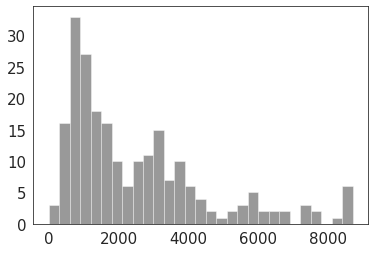

In [39]:
#histogram of size of GapR peaks
bins = np.arange(0,9000,300)
sns.distplot(np.clip(gapR_length,bins[0],bins[-1]),bins=bins,kde=False,norm_hist=False,color='black')
print(np.mean(gapR_length), np.median(gapR_length), np.std(gapR_length),len(gapR_length))

### Fig. 2-figure supplement 2A

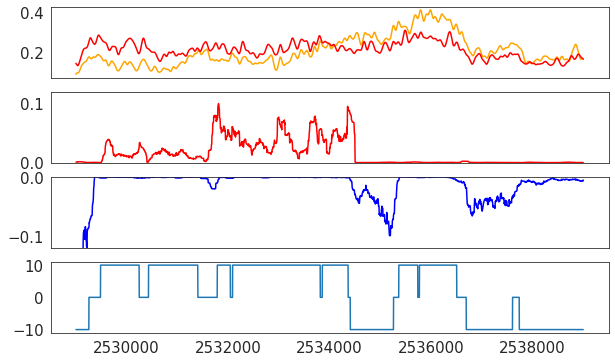

In [40]:
start = 2529000
end = 2539000
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,6), sharey=False)
#axes[0].plot(np.arange(start, end),chip.wtH[start:end],'black')
axes[0].plot(np.arange(start, end),chip.high[start:end],'orange')
axes[0].plot(np.arange(start, end),chip.Rif_high[start:end],'red')

axes[1].plot(np.arange(start, end),(RNAseq['fwd'][start:end]),'red')
axes[2].plot(np.arange(start, end),-(RNAseq['rev'][start:end]),'blue')

axes[1].set_ylim(0, 0.12)
axes[2].set_ylim(-0.12, 0)

axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)

axes[3].plot(np.arange(start, end), genome_gene_representation[0,start:end])

### Fig. 2-figure supplement 2B

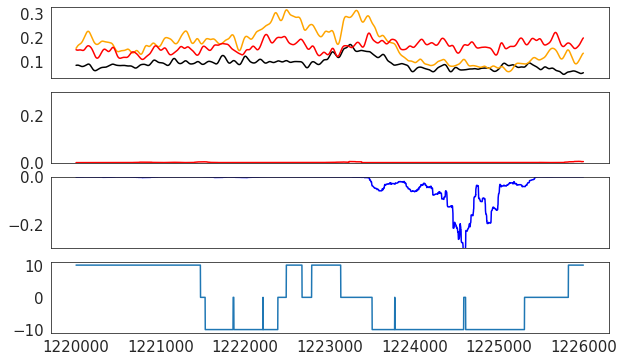

In [41]:
start = 1220000
end = 1226000
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,6), sharey=False)
axes[0].plot(np.arange(start, end),chip.wtH[start:end],'black')
axes[0].plot(np.arange(start, end),chip.high[start:end],'orange')
axes[0].plot(np.arange(start, end),chip.Rif_high[start:end],'red')

axes[1].plot(np.arange(start, end),(RNAseq['fwd'][start:end]),'red')
axes[2].plot(np.arange(start, end),-(RNAseq['rev'][start:end]),'blue')

axes[1].set_ylim(0, 0.3)
axes[2].set_ylim(-0.3, 0)

axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)

axes[3].plot(np.arange(start, end), genome_gene_representation[0,start:end])